In [8]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import numpy as np
import math
import matplotlib.pyplot as plt

In [9]:
(X_train,_),(_,_) = mnist.load_data()

(60000, 28, 28)


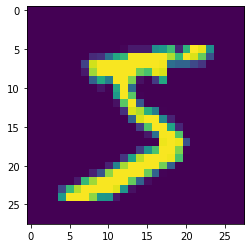

-1.0
1.0
(60000, 28, 28)


In [10]:
print(X_train.shape)
plt.imshow(X_train[0])
plt.show()
#Normalization
X_train = (X_train.astype('float32') - 127.5) / 127.5
print(np.min(X_train))
print(np.max(X_train))
print(X_train.shape) 

In [11]:
TOTAL_EPOCH = 5
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_train.shape[0]/BATCH_SIZE)
HALF_BATCH = 128
NOISE_DIM = 100
adam = Adam(lr = 2e-4, beta_1=0.5)

In [12]:
generator = Sequential()
generator.add(Dense(256, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss = 'binary_crossentropy',optimizer = adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 784)               803600    
Total para

In [13]:
descriminator = Sequential()
descriminator.add(Conv2D(64,(5,5),strides = (2,2),padding = 'same',input_shape = (28,28,1)))
descriminator.add(LeakyReLU(0.2))


descriminator.add(Conv2D(128,(5,5),strides = (2,2),padding = 'same'))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Flatten())

descriminator.add(Dense(1,activation = 'sigmoid'))
descriminator.compile(loss = 'binary_crossentropy',optimizer = adam)
descriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_________________________________________________________________


# Gan

In [14]:
descriminator.trainable = False
gan_input = Input(shape = (NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = descriminator(generated_img)

model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer = adam)

ValueError: Input tensor must be of rank 3, 4 or 5 but was 2.

# Training Loop

W1021 15:05:50.334196 140031953319744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Discriminator_loss 0.1283 Generator_loss 0.5130
Epoch 2 Discriminator_loss 0.0023 Generator_loss 0.0047
Epoch 3 Discriminator_loss 0.0008 Generator_loss 0.0009
Epoch 4 Discriminator_loss 0.0003 Generator_loss 0.0002
Epoch 5 Discriminator_loss 0.0001 Generator_loss 0.0001


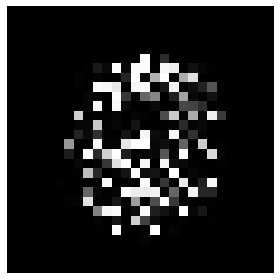

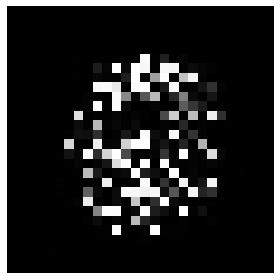

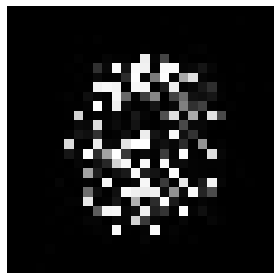

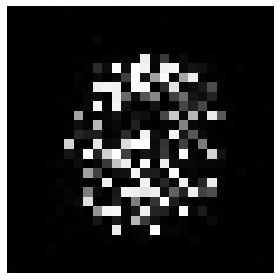

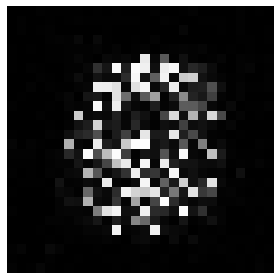

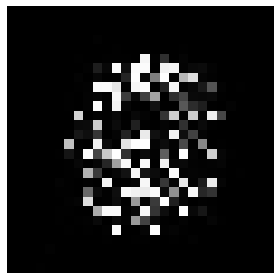

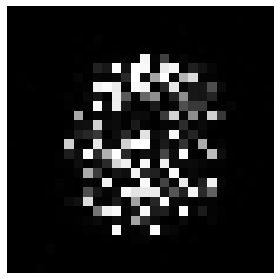

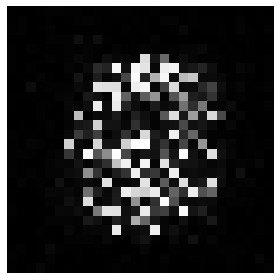

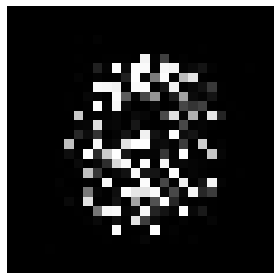

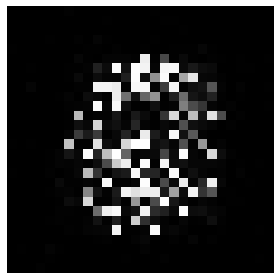

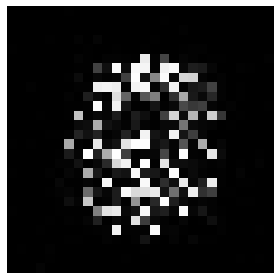

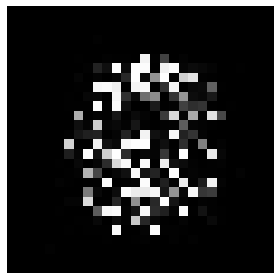

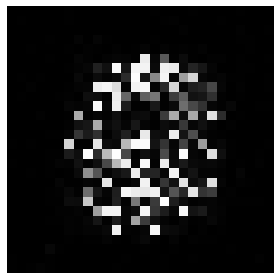

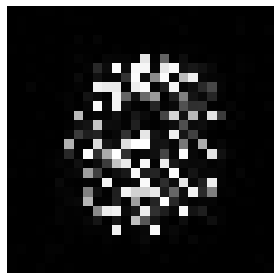

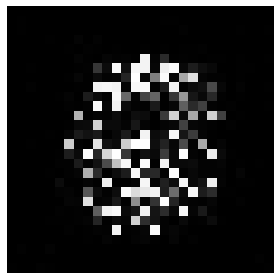

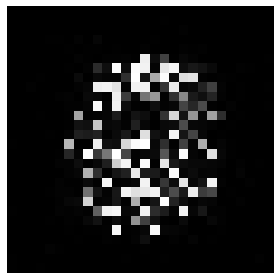

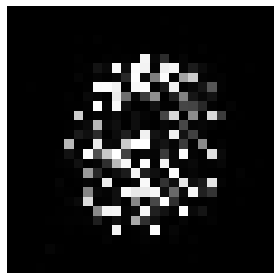

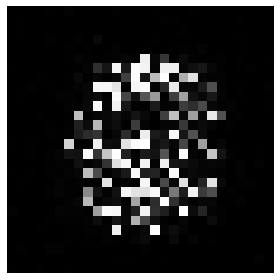

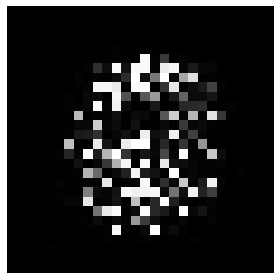

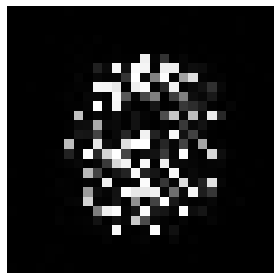

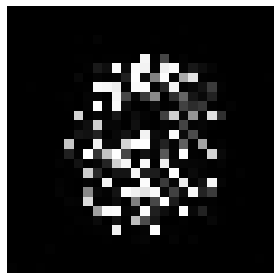

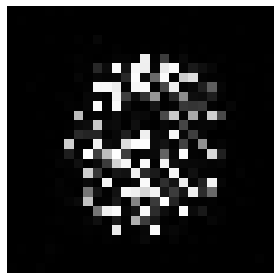

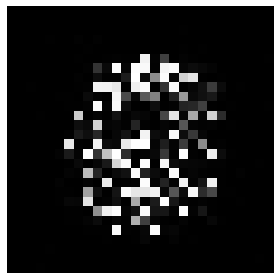

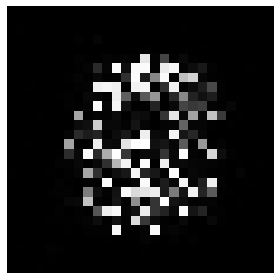

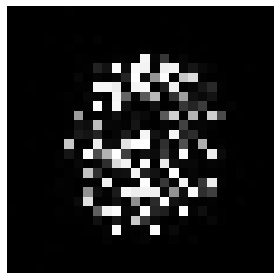

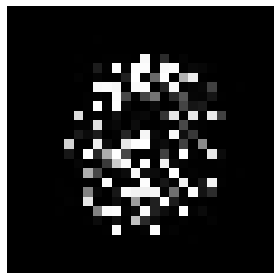

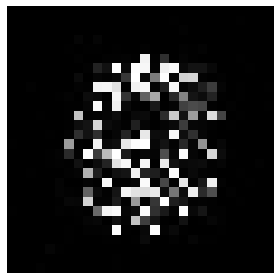

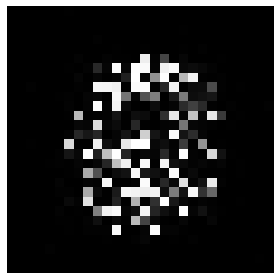

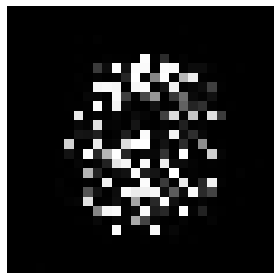

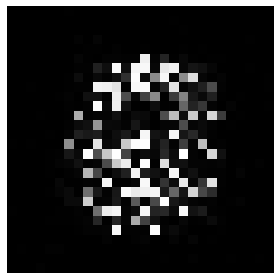

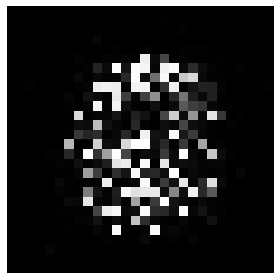

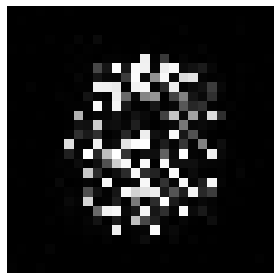

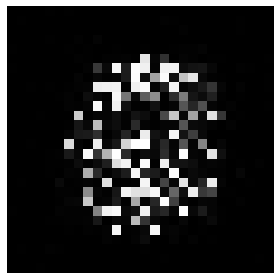

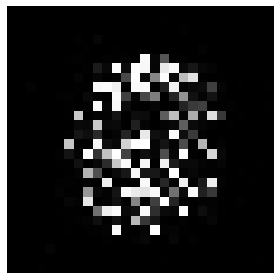

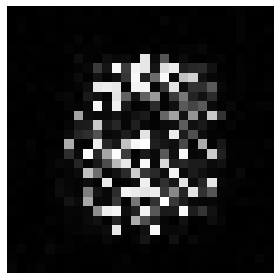

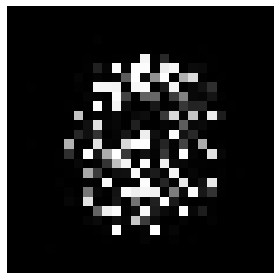

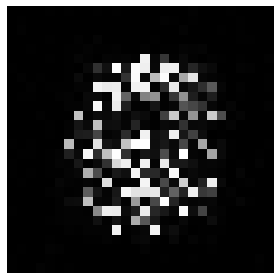

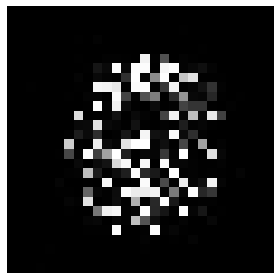

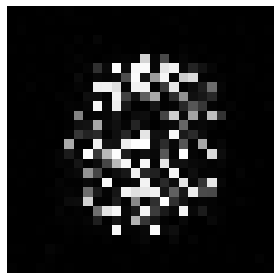

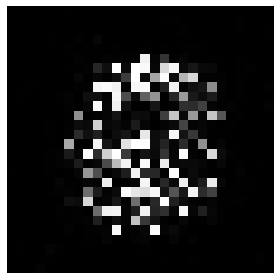

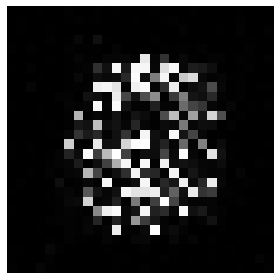

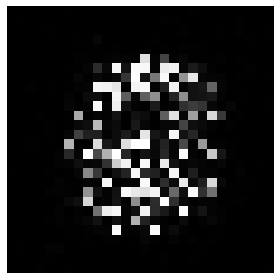

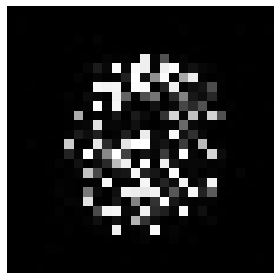

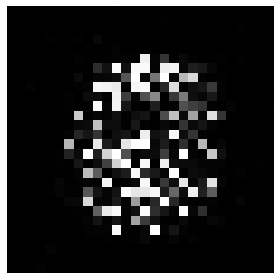

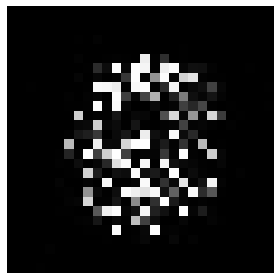

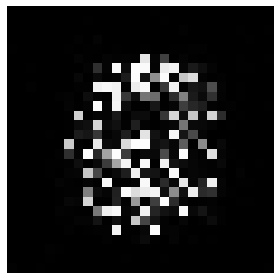

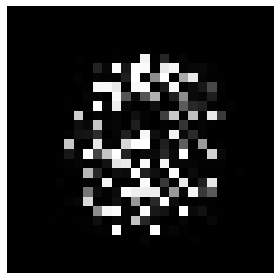

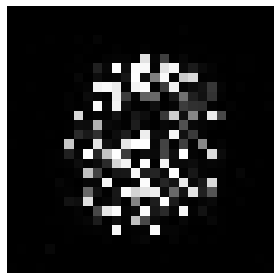

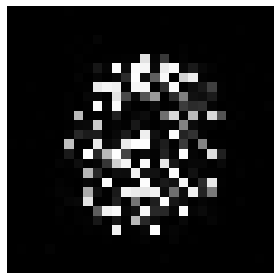

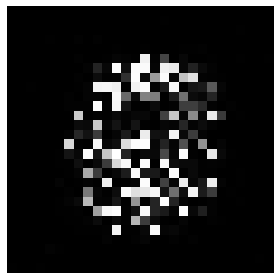

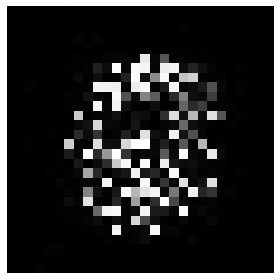

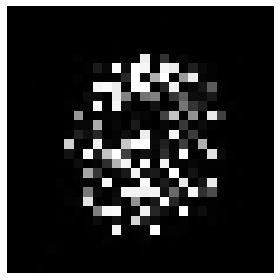

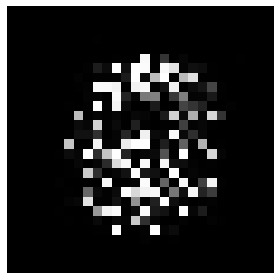

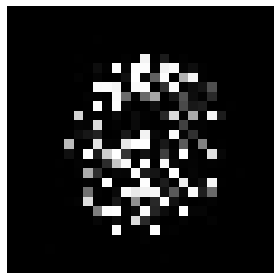

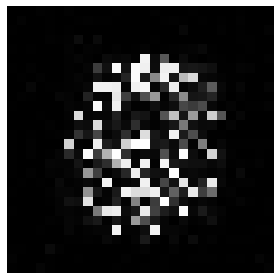

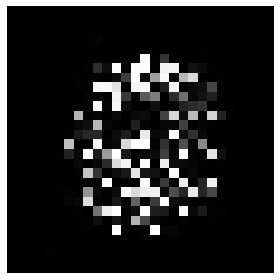

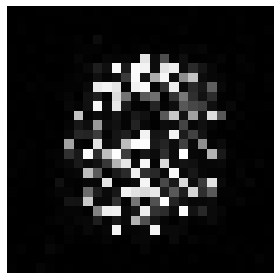

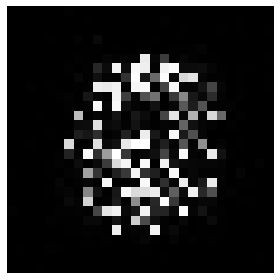

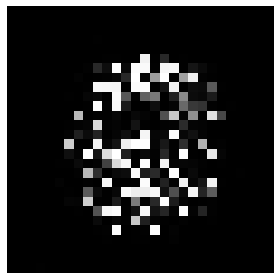

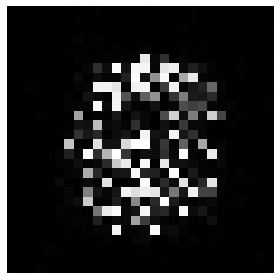

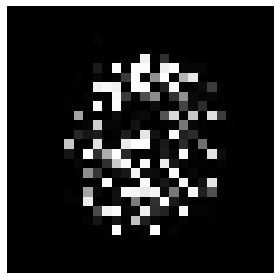

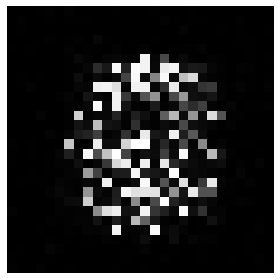

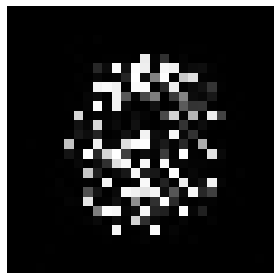

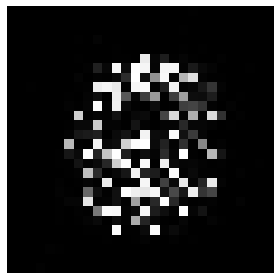

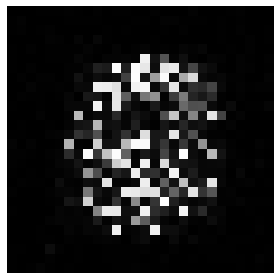

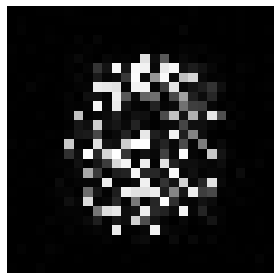

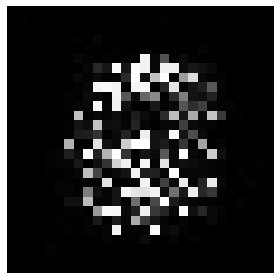

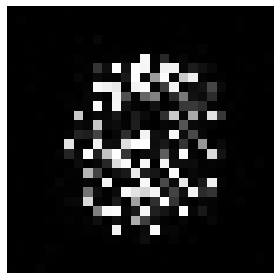

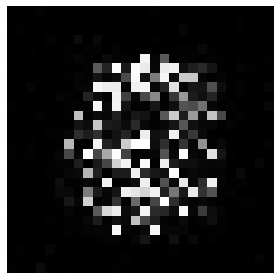

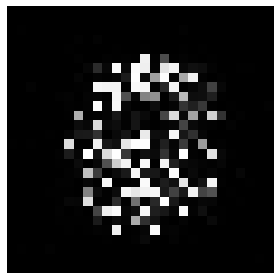

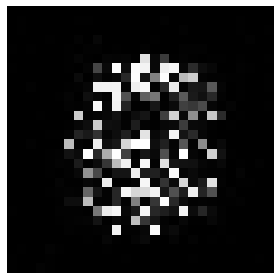

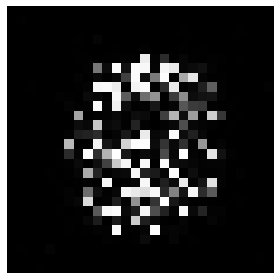

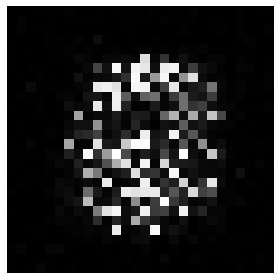

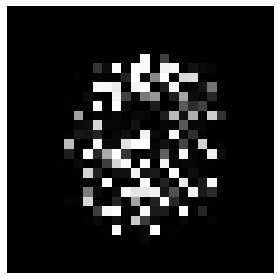

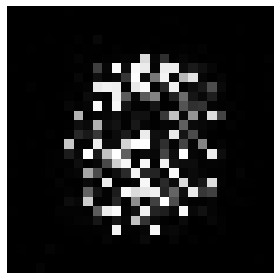

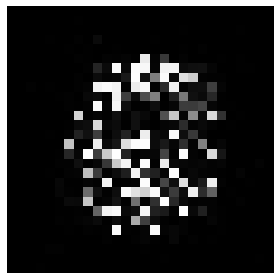

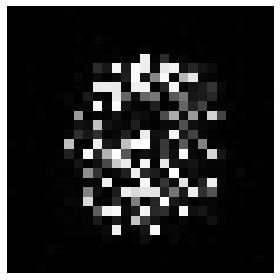

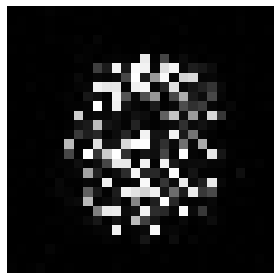

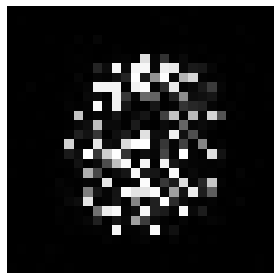

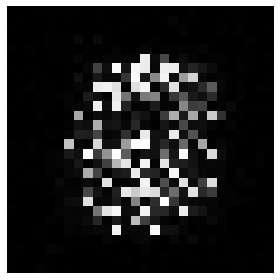

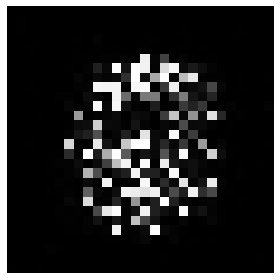

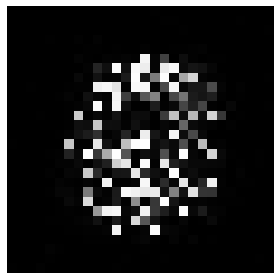

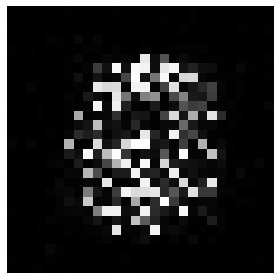

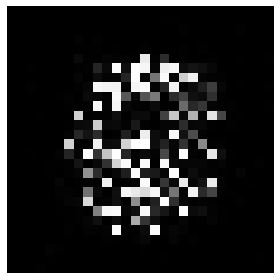

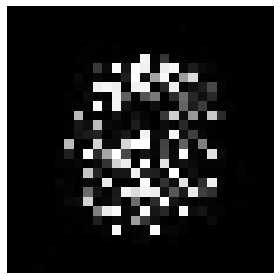

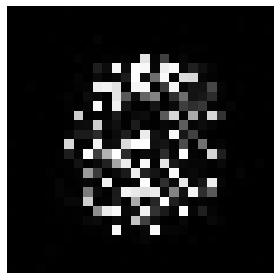

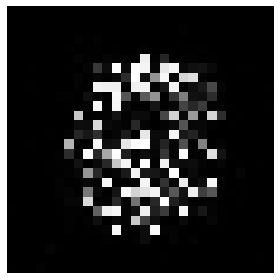

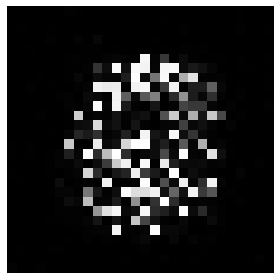

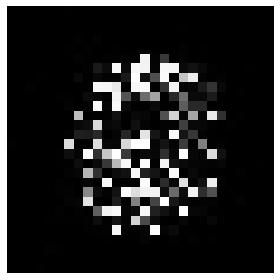

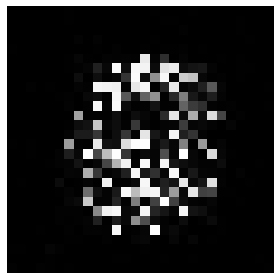

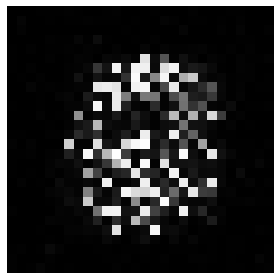

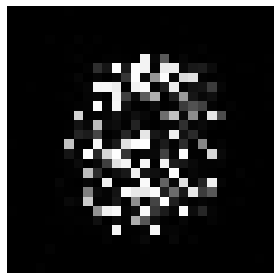

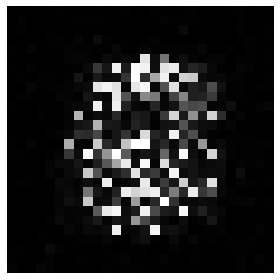

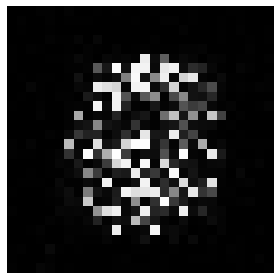

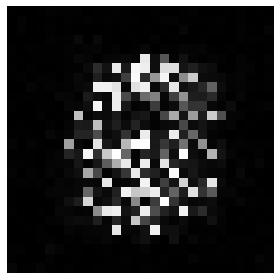

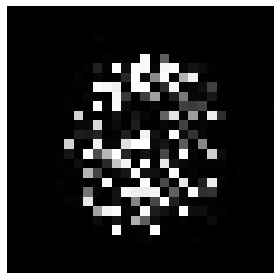

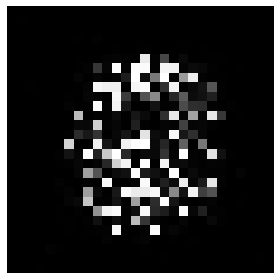

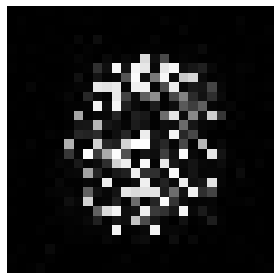

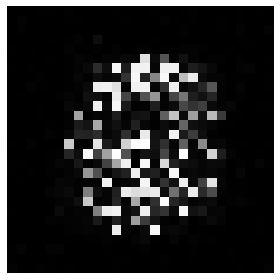

In [8]:
d_losses = []
g_losses = []
X_train = X_train.reshape(-1, 784)
for epoch in range(TOTAL_EPOCH):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    for step in range(NO_OF_BATCHES):
        #Discriminator
        #50% real data + 50% Fake Data
        #Real Data
        idx = np.random.randint(0,X_train.shape[0],HALF_BATCH)
        real_imgs = X_train[idx]
        #Fake data
        noise = np.random.randint(0,1,size = (HALF_BATCH,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        #labels
        real_y = np.ones((HALF_BATCH,1))
        #One sided smoothing for descriminator 0.9
        fake_y = np.zeros((HALF_BATCH,1))
        
        #Train Descriminator
        d_loss_real = descriminator.train_on_batch(real_imgs,real_y)
        
        d_loss_fake = descriminator.train_on_batch(fake_imgs,fake_y)
        
        d_loss = 0.5 * d_loss_real + 0.5 * d_loss_fake
        
        epoch_d_loss += d_loss
        
        #Train Generator
        
        noise = np.random.normal(0,1,size = (BATCH_SIZE,NOISE_DIM))
        
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d Discriminator_loss %.4f Generator_loss %.4f"%((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)
    
    def save_imgs(epoch,samples = 100):
        noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
        generated_imgs = generator.predict(noise)
        generated_imgs = generated_imgs.reshape(samples,28,28)
        plt.figure(figsize = (100,100))
        for i in range(samples):
            plt.plot(50,50,i+1)
            plt.imshow(generated_imgs[i],interpolation = 'nearest',cmap='gray')
            plt.axis("off")
            plt.tight_layout()
            plt.savefig('images/gan_out_epoch{0}.png'.format(epoch+1))
            plt.show()
    if(epoch+1) % 5 == 0:
        generator.save('model/gan_generator_{0}.h5'.format(save_imgs(epoch) ,epoch+1))
   


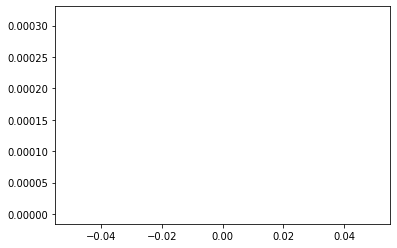

In [9]:
plt.plot(d_loss,label="DISC")
plt.plot(g_loss, label="GEN")
plt.show()